In [2]:
import pandas as pd
import numpy as np
import re


#NLP Libraries
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from gensim.models.phrases import Phrases
from gensim.models import LdaModel
#Visualisation Libraries
import matplotlib.pyplot as plt




In [3]:
df = pd.read_csv('abcnews-date-text.csv')

In [4]:
df.head()

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


In [5]:
df.shape

(1244184, 2)

In [6]:
df

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers
...,...,...
1244179,20211231,two aged care residents die as state records 2...
1244180,20211231,victoria records 5;919 new cases and seven deaths
1244181,20211231,wa delays adopting new close contact definition
1244182,20211231,western ringtail possums found badly dehydrate...


In [7]:
#Taking only 1/10 of the dataset as the full dataset is too computationally intensive for my local machine
df = df.iloc[:df.shape[0]//10]

In [8]:
df = df[df['headline_text'].str.strip() != '']

In [9]:

def pre_process(dataframe, col):
    '''
    This Function performs the pre-processing of the dataframe 

    args:
        dataframe: The dataframe to be preprocessed
    
    Functions:
        
        the following are the steps taken to proprocess the data

        1) Lower case tranformation
        2) Removing Stopwords
        3) Removing Punctuations
        4) Removing Numbers
        5) Removing Single Alphabets
       
    '''
    stop_words = stopwords.words('english')
    stop_words.extend(['say'])

    #Remove all stopwords
    dataframe[col] = dataframe[col].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

    #Remove all punctuations
    dataframe[col] = dataframe[col].apply(lambda x: re.sub('[^\w\s]', ' ', x))

    #Removing Numbers
    dataframe[col] = dataframe[col].apply(lambda x: re.sub('\d+' , ' ' , x))

    #remove single alphabets
    dataframe[col] = dataframe[col].apply(lambda x: re.sub('\b[a-zA-Z]\s', ' ' , x))


In [10]:
pre_process(df , 'headline_text')

In [11]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

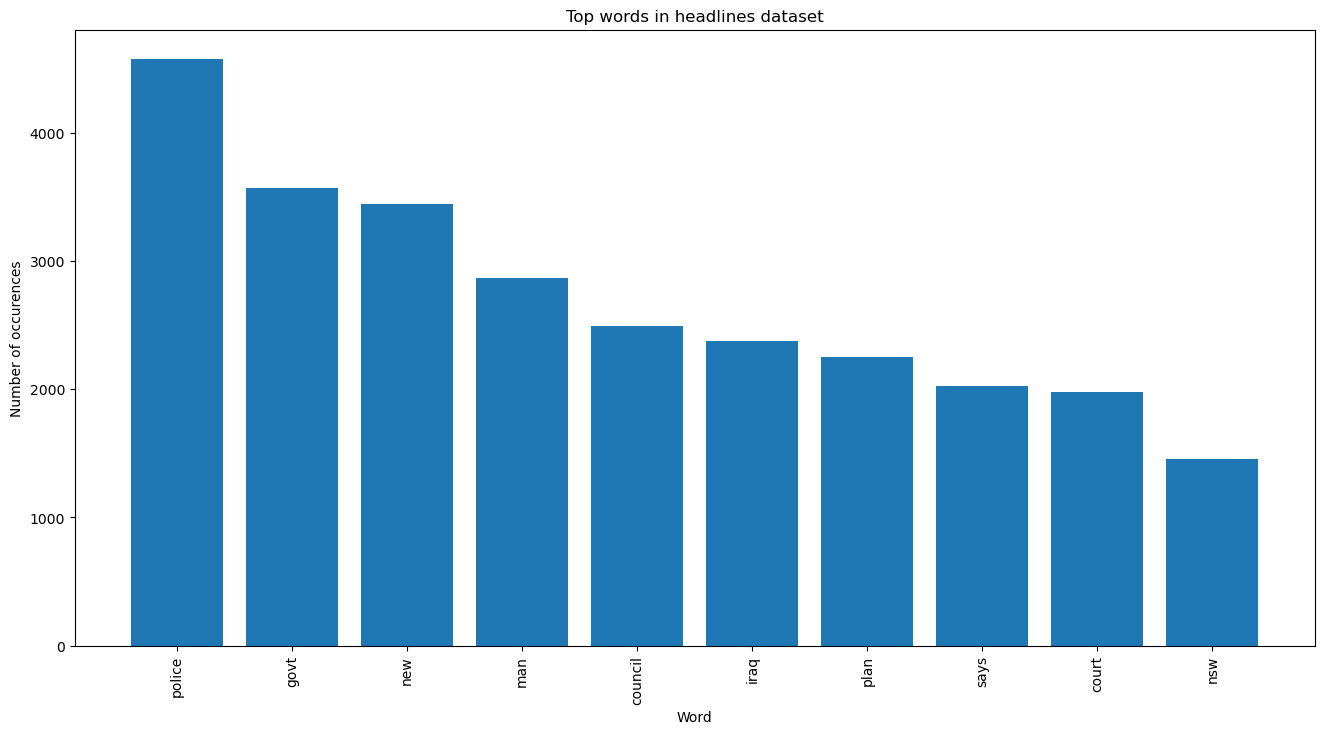

In [12]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=10,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df.headline_text)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values)
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation='vertical')
ax.set_title('Top words in headlines dataset')
ax.set_xlabel('Word')
ax.set_ylabel('Number of occurences')
plt.show()

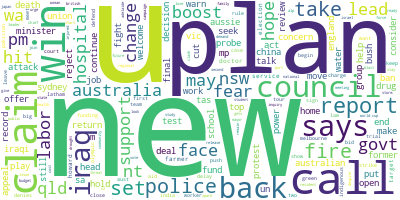

In [13]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df['headline_text'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

### Performin Topic Modelling

#### Creating Bigrams

In [14]:
nlp = spacy.load('en_core_web_sm' , disable=['parser' , 'ner'])


In [15]:
def lemmatize_text(text , allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV' ]):
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
    return ' '.join(lemmatized_tokens)

In [16]:
df['headline_text'] = df['headline_text'].apply(lemmatize_text)

In [17]:
docs  = df.headline_text.values.tolist()

In [18]:
from nltk.tokenize import RegexpTokenizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

In [19]:
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [20]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary



In [21]:
id2word = Dictionary(docs)
id2word.filter_extremes(no_below=20, no_above=0.5)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in docs]
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1)]]


In [22]:
[[(id2word[i], freq) for i, freq in doc] for doc in corpus[:1]]


[[('community', 1), ('decide', 1), ('licence', 1)]]

In [23]:
num_topics = 10
chunksize = 25000
passes = 20
iterations = 400
eval_every = None 

In [24]:
from gensim.models.ldamulticore import LdaMulticore

In [26]:
model = LdaMulticore(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    eta='auto',
    iterations=iterations,
    num_topics=10,
    passes=passes,
    eval_every=eval_every
)

In [27]:
print(model.print_topics())
doc_lda = model[corpus]

[(0, '0.051*"man" + 0.040*"kill" + 0.033*"charge" + 0.020*"face" + 0.018*"police" + 0.017*"murder" + 0.017*"attack" + 0.017*"car" + 0.016*"crash" + 0.013*"trial"'), (1, '0.025*"say" + 0.024*"court" + 0.022*"set" + 0.018*"reject" + 0.016*"test" + 0.014*"case" + 0.013*"death" + 0.013*"decision" + 0.012*"appeal" + 0.012*"hear"'), (2, '0.030*"fire" + 0.017*"job" + 0.012*"market" + 0.012*"fight" + 0.012*"record" + 0.012*"farmer" + 0.012*"continue" + 0.012*"aid" + 0.012*"time" + 0.011*"close"'), (3, '0.021*"report" + 0.019*"consider" + 0.016*"deny" + 0.012*"war" + 0.012*"port" + 0.011*"talk" + 0.011*"final" + 0.011*"clash" + 0.010*"plan" + 0.010*"move"'), (4, '0.024*"miss" + 0.020*"take" + 0.016*"search" + 0.015*"get" + 0.015*"find" + 0.014*"put" + 0.014*"head" + 0.012*"new" + 0.012*"claim" + 0.011*"spark"'), (5, '0.032*"plan" + 0.021*"govt" + 0.019*"health" + 0.018*"urge" + 0.018*"service" + 0.013*"deal" + 0.013*"defend" + 0.012*"public" + 0.011*"work" + 0.010*"indigenous"'), (6, '0.055*"po

In [28]:
import pyLDAvis
import pyLDAvis.gensim
    # Visualize the topics
pyLDAvis.enable_notebook()

In [29]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(model, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.127464  0.154737       1        1  12.276659
0     -0.342706  0.034781       2        1  11.394639
8      0.162450  0.083422       3        1  10.160284
2      0.102530 -0.090731       4        1   9.834753
1     -0.029131  0.020699       5        1   9.737706
3      0.127905  0.085478       6        1   9.660847
6     -0.107244  0.135951       7        1   9.539170
7      0.040041 -0.291221       8        1   9.533618
4     -0.006889 -0.089572       9        1   9.067662
9     -0.074420 -0.043544      10        1   8.794661, topic_info=       Term         Freq        Total Category  logprob  loglift
249     man  2901.000000  2901.000000  Default  30.0000  30.0000
210  police  4500.000000  4500.000000  Default  29.0000  29.0000
8      call  2311.000000  2311.000000  Default  28.0000  28.0000
469    kill  2189.000000  2189.000000  Default  27.0000  27.0000
22      win  1952.000000  1952.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
45    boost   296.147285  1526.000130  Topic10  -4.9453   0.7915
84      cut   252.201083   781.297699  Topic10  -5.1060   1.3003
6      fire   292.121820  1717.203984  Topic10  -4.9590   0.6597
65   attack   269.473893  1347.535363  Topic10  -5.0397   0.8215
37     take   273.055896  1551.241581  Topic10  -5.0265   0.6939

[728 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1506      1  0.166187     abuse
1506      3  0.005665     abuse
1506      5  0.666637     abuse
1506      6  0.005665     abuse
1506      7  0.120863     abuse
...     ...       ...       ...
1605      9  0.010461  year_old
1934      4  0.953452      zone
1934      5  0.014446      zone
1934      8  0.021669      zone
1934      9  0.007223      zone

[2870 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 9, 3, 2, 4, 7, 8, 5, 10])

Changing chunksize give a different size

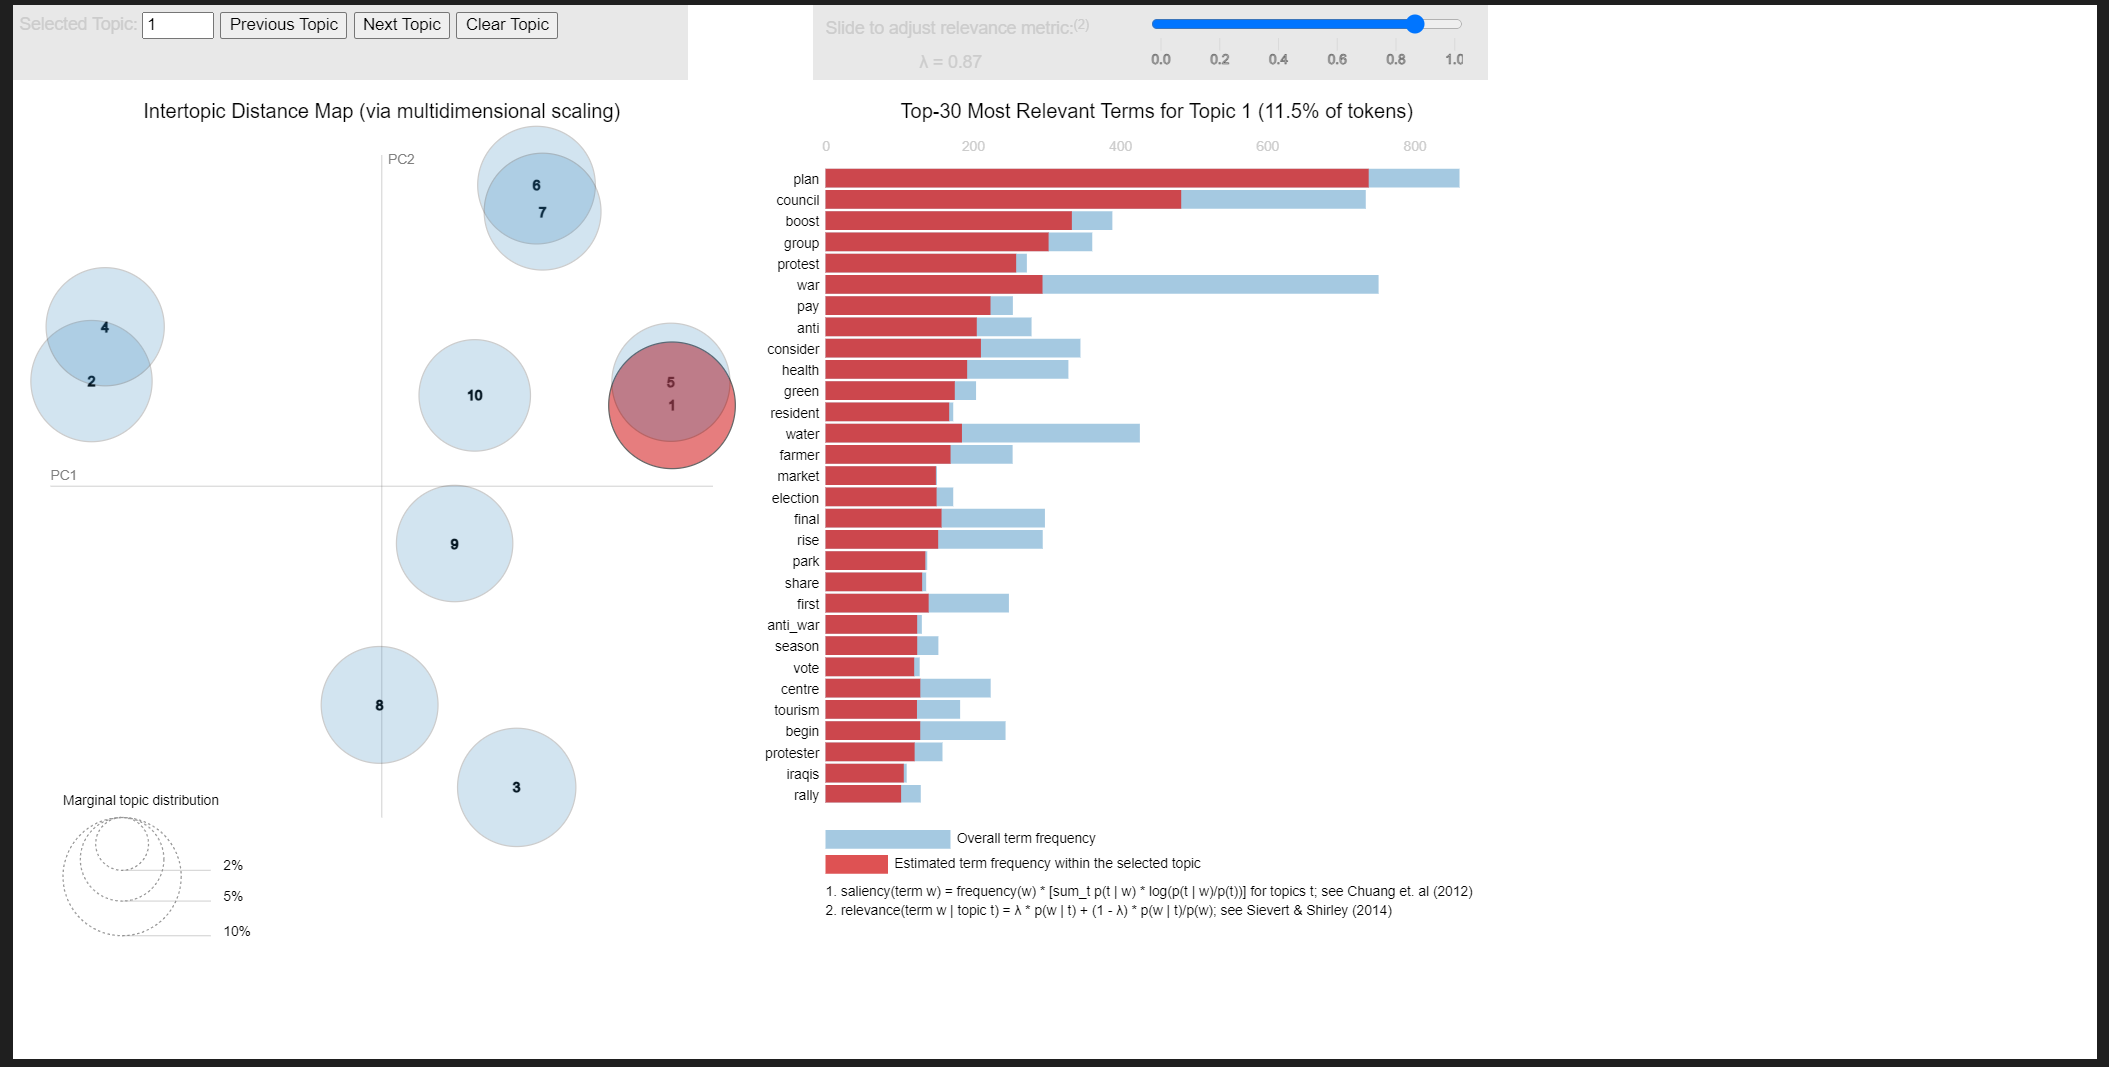